In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.2 MB/s eta 0:00:00


In [5]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import rasterio as rio
from rasterio.enums import Resampling
import json
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from PIL import ImageColor
import skimage as ski
from skimage.exposure import rescale_intensity
import scipy
from rasterio.features import shapes

In [6]:
# Location of data
lc_dir = '/content/data/lc.json'
sample_dir = "/content/data/Sample_LC_v1.geojson"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [9]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

,palette,values,label,values_normalize
0,#006400,2001,Primary dryland forest,1
1,#228B22,2002,Secondary dryland forest,2
2,#4B0082,2004,Primary mangrove forest,3
3,#808000,2005,Primary swamp forest,4
4,#32CD32,2006,Plantation forest,5
5,#90EE90,2007,Dry shrub,6
6,#FF4500,2010,Estate crop,7
7,#F08080,2012,Settlement,8
8,#D2B48C,2014,Bare ground,9
9,#ADFF2F,3000,Savanna and grasses,10


(14029, 5)


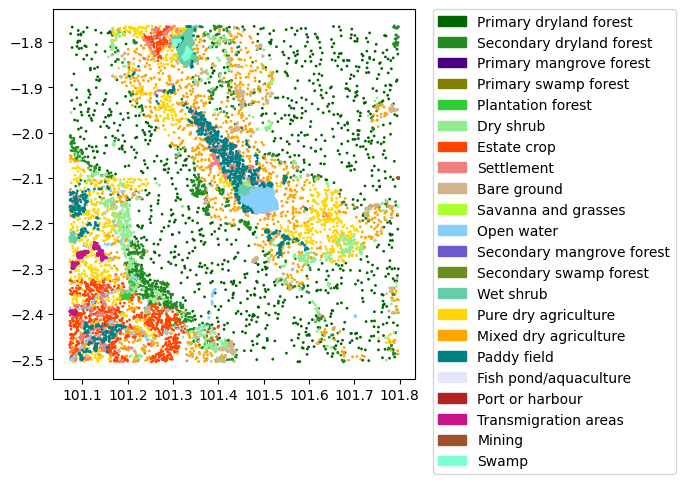

In [10]:
# Load sample
sample = gpd.read_file(sample_dir)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

# Plot sample
sample.plot(column="value", cmap=cmap, markersize=1)
plt.legend(**legend)

# Sample with extract
sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)

In [11]:
# Load landsat image
landsat = rio.open(landsat_dir)
landsat_image = landsat.read() / 1e4

,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,14024,50011,POINT (101.32983 -1.83297),22,Swamp,0.0187,0.0235,0.0419,0.0425,0.1372,0.1336,0.0820,0.0026
14025,14025,50011,POINT (101.33306 -1.82461),22,Swamp,0.0205,0.0240,0.0407,0.0496,0.1509,0.1315,0.0788,0.0027
14026,14026,50011,POINT (101.33064 -1.8362),22,Swamp,0.0239,0.0278,0.0546,0.0443,0.2668,0.1430,0.0719,0.0023
14027,14027,50011,POINT (101.30207 -1.80063),22,Swamp,0.0315,0.0407,0.0621,0.0588,0.2338,0.1386,0.0839,0.0031


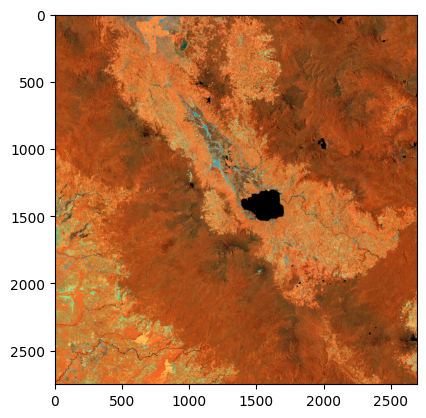

In [12]:
# False color composite
out_range = (0, 1)
red = rescale_intensity(landsat_image[4], in_range=(0.1, 0.4), out_range=out_range)
green = rescale_intensity(landsat_image[5], in_range=(0.05, 0.3), out_range=out_range)
blue = rescale_intensity(landsat_image[6], in_range=(0.025, 0.25), out_range=out_range)
arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Extract raster value
landsat_extract = np.stack(
    [x for x in landsat.sample(coords)]
) / 1e4
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]] = landsat_extract
sample_extract

In [13]:
# Load palsar image
palsar = rio.open(palsar_dir)
palsar_image = palsar.read(
    out_shape=(palsar.count, landsat_image.shape[1], landsat_image.shape[2]),
    resampling=Resampling.bilinear,
) / 1e3

,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019,-7.608,-11.281
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027,-7.931,-11.993
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033,-7.901,-11.999
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027,-7.223,-11.135
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024,-8.136,-12.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,14024,50011,POINT (101.32983 -1.83297),22,Swamp,0.0187,0.0235,0.0419,0.0425,0.1372,0.1336,0.0820,0.0026,-12.472,-19.294
14025,14025,50011,POINT (101.33306 -1.82461),22,Swamp,0.0205,0.0240,0.0407,0.0496,0.1509,0.1315,0.0788,0.0027,-11.963,-19.554
14026,14026,50011,POINT (101.33064 -1.8362),22,Swamp,0.0239,0.0278,0.0546,0.0443,0.2668,0.1430,0.0719,0.0023,-9.416,-15.761
14027,14027,50011,POINT (101.30207 -1.80063),22,Swamp,0.0315,0.0407,0.0621,0.0588,0.2338,0.1386,0.0839,0.0031,-10.746,-18.832


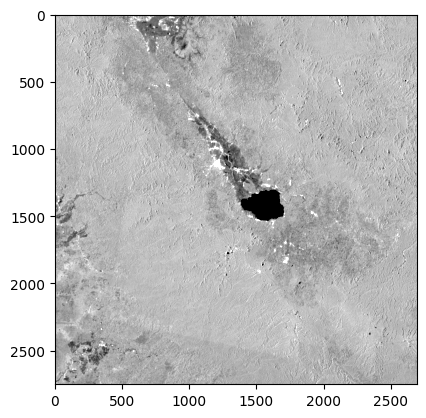

In [14]:
# Plot palsar image
plt.imshow(palsar_image[0], cmap="gray", vmin=-15, vmax=-5)

# Extract raster value
palsar_extract = np.stack([x for x in palsar.sample(coords)]) / 1e3
sample_extract[["HH", "HV"]] = palsar_extract
sample_extract

In [15]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 9820
Test size: 4209


In [16]:
# Make random forest model
predictors = ["B2", "B3", 'B4', 'B5', 'B6', 'B7', 'HH', 'HV']
model = RandomForestClassifier(100)
model.fit(
    train[predictors],
    train["value"]
)

RandomForestClassifier()

              precision    recall  f1-score   support

           1       0.53      0.74      0.62       298
           2       0.43      0.43      0.43       309
           5       0.53      0.75      0.62       322
           6       0.22      0.11      0.14       293
           7       0.51      0.61      0.56       280
           8       0.59      0.56      0.58       303
           9       0.42      0.35      0.38       321
          11       0.95      0.88      0.91       295
          14       0.57      0.61      0.59       303
          15       0.28      0.20      0.24       291
          16       0.28      0.22      0.25       289
          17       0.65      0.68      0.66       297
          20       0.70      0.74      0.72       308
          21       0.33      0.14      0.20         7
          22       0.82      0.84      0.83       293

    accuracy                           0.55      4209
   macro avg       0.52      0.53      0.51      4209
weighted avg       0.53   

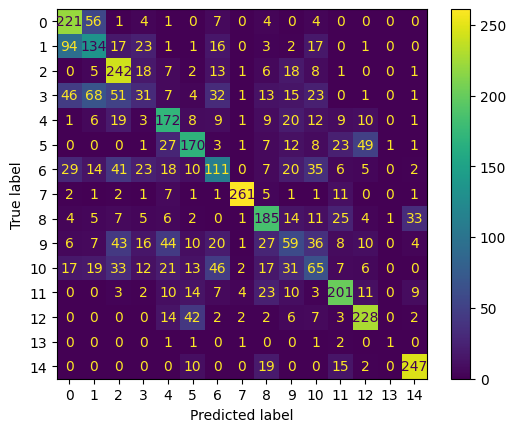

In [17]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['value'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['value'], test_apply)
print(report)

In [18]:
# Load image
combine_image = np.concatenate((landsat_image, palsar_image), 0)
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9", "HH", "HV"],
)
table_image

,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0.0151,0.0165,0.0329,0.0213,0.2570,0.1103,0.0428,0.0023,-7.973,-12.063
1,0.0166,0.0184,0.0335,0.0215,0.2700,0.1119,0.0458,0.0025,-8.477,-12.280
2,0.0188,0.0198,0.0384,0.0216,0.3084,0.1288,0.0518,0.0026,-8.904,-12.676
3,0.0204,0.0221,0.0420,0.0241,0.3381,0.1348,0.0528,0.0025,-8.938,-13.058
4,0.0210,0.0231,0.0476,0.0274,0.3625,0.1518,0.0588,0.0024,-8.600,-13.174
...,...,...,...,...,...,...,...,...,...,...
7405687,0.0098,0.0139,0.0331,0.0209,0.2861,0.1183,0.0460,0.0026,-7.839,-11.874
7405688,0.0091,0.0137,0.0331,0.0202,0.2860,0.1191,0.0452,0.0027,-7.465,-11.422
7405689,0.0091,0.0136,0.0337,0.0208,0.2934,0.1197,0.0465,0.0027,-7.270,-11.149
7405690,0.0107,0.0146,0.0353,0.0207,0.2875,0.1156,0.0434,0.0027,-6.970,-11.184


In [19]:
# Predict table image
prediction = model.predict(table_image[predictors])
prediction

array([1, 1, 1, ..., 1, 1, 1])

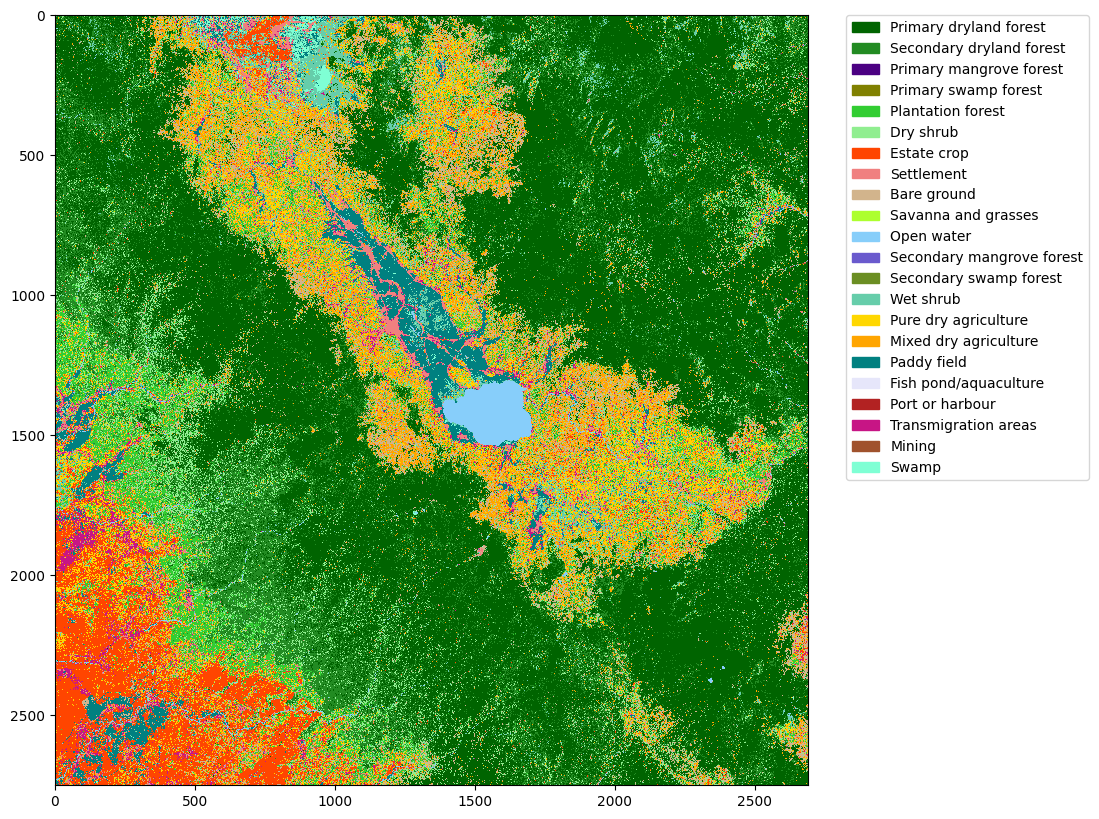

In [20]:
# Prediction to image again
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

In [21]:
# Save image to geotiff
output = rio.open(
    "data/LULC.tif",
    "w",
    "COG",
    count=1,
    width=prediction_image.shape[1],
    height=prediction_image.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(prediction_image, 1)
output.close()

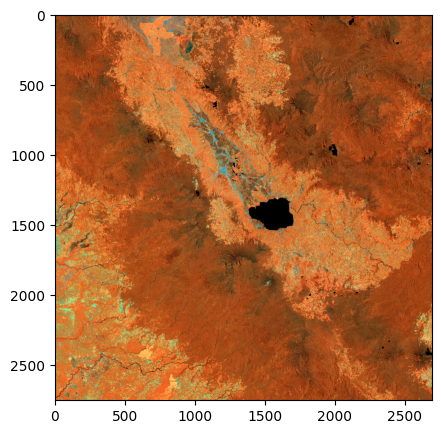

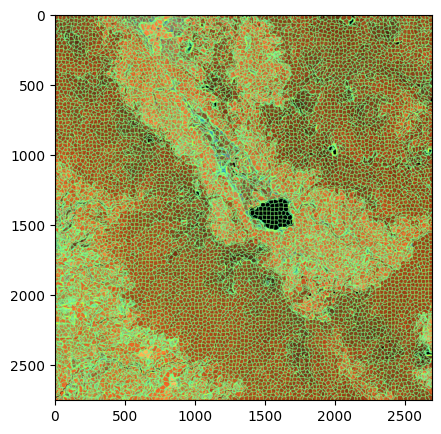

In [22]:
# Image segmentation

# Do uniform filter to composite image
seed_image = composite
plt.figure(figsize=(5, 5))
plt.imshow(seed_image)

# Segmentation
segment = ski.segmentation.slic(
    seed_image, n_segments=10000, compactness=5, sigma=5
)
plt.figure(figsize=(5, 5))
plt.imshow(ski.segmentation.mark_boundaries(composite, segment, outline_color=(0, 255, 255)))

In [23]:
# Get the mode of each segment
segment_unique = np.unique(segment)
lc_segment = segment.copy()
for x in segment_unique:
    lc_segment[segment == x] = scipy.stats.mode(prediction_image[segment == x]).mode
lc_segment

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1]])

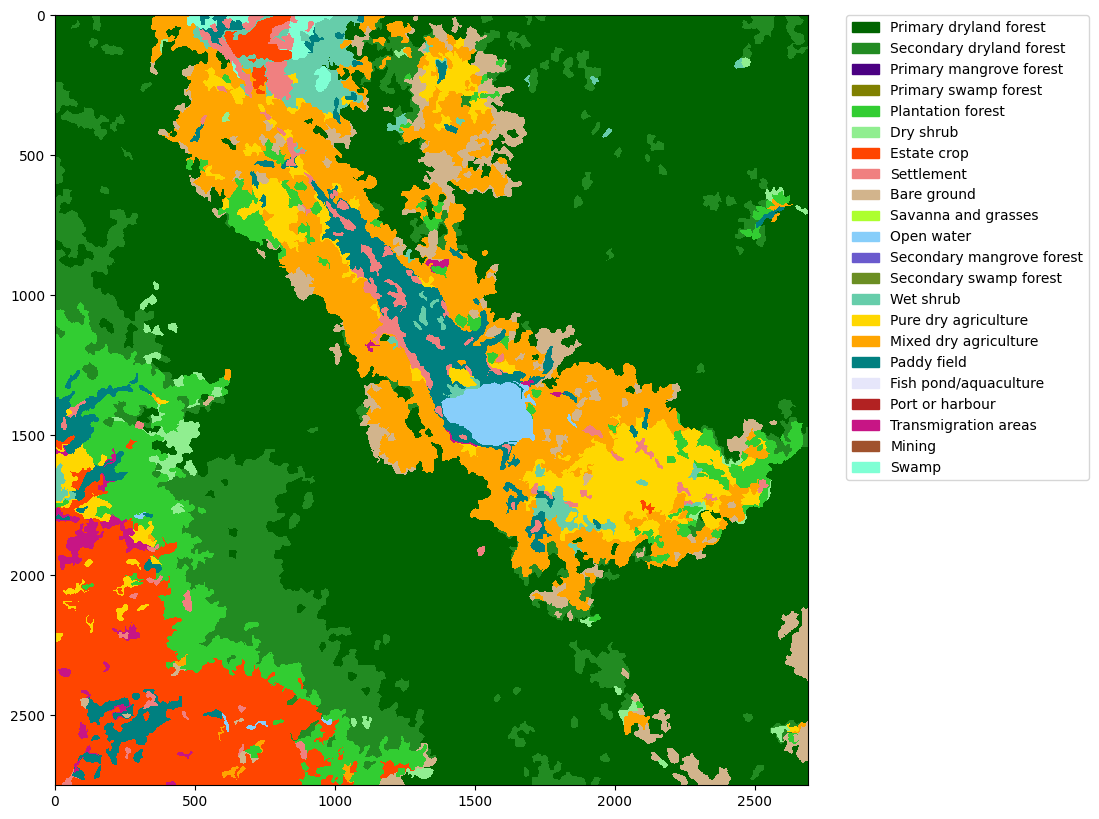

In [24]:
# Show to plot the segmented LC
plt.figure(figsize=(10, 10))
plt.imshow(lc_segment, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

In [25]:
# Save image to geotiff
output = rio.open(
    "data/LULC_Segment.tif",
    "w",
    "COG",
    count=1,
    width=lc_segment.shape[1],
    height=lc_segment.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(lc_segment, 1)
output.close()

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


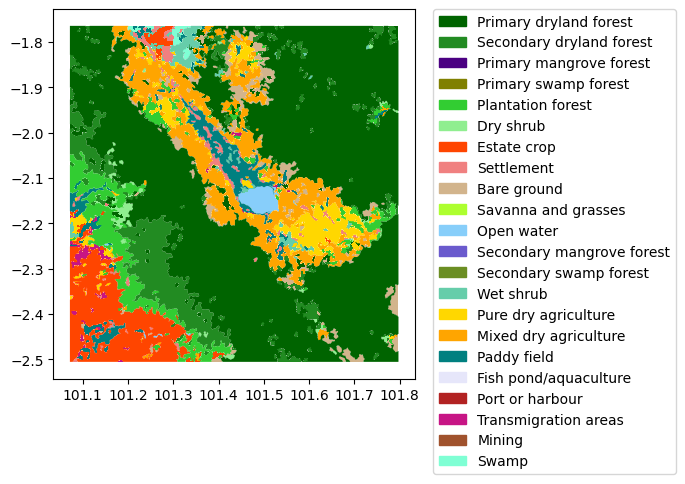

In [26]:
# Convert raster to shapefile
lc_vector = [{ "type": "Feature", "properties": { "lc": x[1] }, "geometry": x[0] } for x in shapes(lc_segment.astype('uint8'), transform=landsat.transform)]
lc_vector = json.dumps({
    "type": "FeatureCollection",
	"properties": {},
	"features": lc_vector
})

# Read as geodataframe
lc_df = gpd.read_file(lc_vector, driver='GeoJSON')

# Plot it
lc_df.plot(column="lc", cmap=cmap)
plt.legend(**legend)

In [27]:
# Add another column such as palette and label
lc_df["palette"] = lc_df["lc"].map(dict_palette_hex)
lc_df["label"] = lc_df["lc"].map(dict_label)

# Save the file
lc_df.to_file("data/LULC_Shapefile.shp")